In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/sp500_ciks.csv', dtype=str)
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,0000815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


In [3]:
def get_company_cik(ticker):
    return df.loc[df.Symbol == ticker, 'CIK'].values[0]

In [4]:
def get_company_facts(ticker):
    cik = get_company_cik(ticker)
    with open(f'data/sec_bulk_data/CIK{cik}.json') as f:
        facts = json.load(f)
    return facts

In [5]:
def get_company_concepts(ticker):
    facts = get_company_facts(ticker)
    return facts['facts']['us-gaap'].keys()

In [6]:
def get_concept_description(ticker, concept, label=False):
    facts = get_company_facts(ticker)
    concept = facts['facts']['us-gaap'][concept]
    try:
        if label:
            return concept['label'], concept['description']
        return concept['description']
    except KeyError as e:
        print(f'KeyError: The specified company does not have a concept of \'{concept}\'')

In [7]:
def get_concept_values(ticker, concept, frame_only=True, frame_filter='Q'):
    facts = get_company_facts(ticker)
    concept_values = facts['facts']['us-gaap'][concept]['units']['USD']
    if frame_only:
        concept_values = [item for item in concept_values if 'frame' in item.keys()]
        concept_values = [item for item in concept_values if frame_filter in item['frame']]
    return concept_values

In [8]:
def plot_concept(ticker, concept):
    # Storing the data in a dataframe for easier plotting
    concept_values = get_concept_values(ticker, concept)
    df = pd.DataFrame({'Date': [pd.to_datetime(item['end']) for item in concept_values],
                       'Frame': [item['frame'] for item in concept_values],
                       concept: [item['val'] for item in concept_values]})
    
    # Changing format of the Frame column
    def frame_format(x):
        q = x[x.index('Q'):x.index('Q')+2]
        y = x[4:6]
        return f"{q}'{y}"
    df.Frame = df.Frame.apply(frame_format)
    
    # Plotting
    sns.barplot(data=df, x='Date', y=concept, color='#00b894')
    sns.despine()
    plt.title(f'{ticker} - {concept}', fontweight='bold')
    plt.xticks(ticks=np.arange(0, len(df), 4), labels=df.Frame[::4])

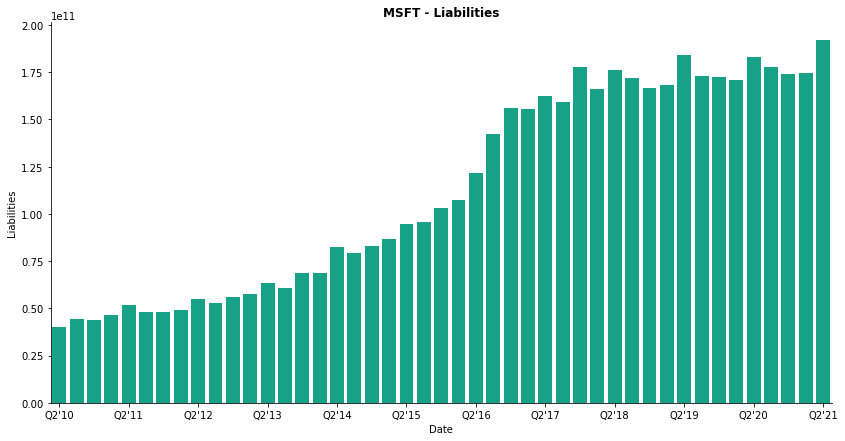

In [9]:
fig = plt.figure(figsize=(14, 7))
plot_concept('MSFT', 'Liabilities')